# Bayesian Temporal Matrix Factorization

**Published**: October 8, 2019

**Revised**: October 8, 2020

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the [**transdim**](https://github.com/xinychen/transdim/blob/master/imputer/BTMF.ipynb) repository.

This notebook shows how to implement the Bayesian Temporal Matrix Factorization (BTMF), a fully Bayesian matrix factorization model, on some real-world data sets. To overcome the missing data problem in multivariate time series, BTMF takes into account both low-rank matrix structure and time series autoregression. For an in-depth discussion of BTMF, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Xinyu Chen, Lijun Sun (2019). <b>Bayesian temporal factorization for multidimensional time series prediction</b>. arXiv:1910.06366. <a href="https://arxiv.org/pdf/1910.06366.pdf" title="PDF"><b>[PDF]</b></a> 
</font>
</div>

## Abstract

Large-scale and multidimensional spatiotemporal data sets are becoming ubiquitous in many real-world applications such as monitoring traffic and air quality. Making predictions on these time series has become a critical challenge due to not only the large-scale and high-dimensional nature but also the considerable amount of missing data. In this work, we propose a Bayesian Temporal Matrix Factorization (BTMF) model for modeling multidimensional time series - and in particular spatiotemporal data - in the presence of missing values. By integrating low-rank matrix factorization and vector autoregressive (VAR) process into a single probabilistic graphical model, our model can effectively perform predictions without imputing those missing values. We develop efficient Gibbs sampling algorithms for model inference and test BTMF on several real-world spatiotemporal data sets (i.e., a typical kind of multivariate time series data) for both missing data imputation and short-term rolling prediction tasks. This post is mainly about BTMF and its **`Python`** implementation with an application of spatiotemporal data imputation.

## Motivation



## Problem Description

We assume a spatiotemporal setting for multidimensional time series data throughout this work. In general, modern spatiotemporal data sets collected from sensor networks can be organized as matrix time series. For example, we can denote by matrix $Y\in\mathbb{R}^{N\times T}$ a multivariate time series collected from $N$ locations/sensors on $T$ time points, with each row $$\boldsymbol{y}_{i}=\left(y_{i,1},y_{i,2},...,y_{i,t-1},y_{i,t},y_{i,t+1},...,y_{i,T}\right)$$
corresponding to the time series collected at location $i$.

As mentioned, making accurate predictions on incomplete time series is very challenging, while missing data problem is almost inevitable in real-world applications. Figure 1 illustrates the prediction problem for incomplete time series data. Here we use $(i,t)\in\Omega$ to index the observed entries in matrix $Y$.

<img src="../images/graphical_matrix_time_series.png" alt="drawing" width="500"/>

> **Figure 1**: Illustration of multivariate time series and the prediction problem in the presence of missing values (green: observed data; white: missing data; red: prediction).


## Model Description

Given a partially observed spatiotemporal matrix $Y\in\mathbb{R}^{N \times T}$, one can factorize it into a spatial factor matrix $W\in\mathbb{R}^{R \times N}$ and a temporal factor matrix $X\in\mathbb{R}^{R \times T}$ following general matrix factorization model:
\begin{equation}
Y\approx W^{\top}X,
\label{btmf_equation1}
\end{equation}
and element-wise, we have
\begin{equation}
y_{it}\approx \boldsymbol{w}_{i}^\top\boldsymbol{x}_{t}, \quad \forall (i,t),
\label{btmf_equation2}
\end{equation}
where vectors $\boldsymbol{w}_{i}$ and $\boldsymbol{x}_{t}$ refer to the $i$-th column of $W$ and the $t$-th column of $X$, respectively.

The standard matrix factorization model is a good approach to deal with the missing data problem; however, it cannot capture the dependencies among different columns in $X$, which are critical in modeling time series data. To better characterize the temporal dependencies and impose temporal smoothness, a novel AR regularizer is introduced on $X$ in TRMF (i.e., Temporal Regularizer Matrix Factorization proposed by [Yu et al., 2016](https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf)):
\begin{equation} \label{equ:VAR}
\begin{aligned}
    \boldsymbol{x}_{t+1}&=\sum\nolimits_{k=1}^{d}A_{k}\boldsymbol{x}_{t+1-h_k}+\boldsymbol{\epsilon}_t, \\
    &=A^\top \boldsymbol{v}_{t+1}+\boldsymbol{\epsilon}_{t}, \\
\end{aligned}
\end{equation}
where $\mathcal{L}=\left\{h_1,\ldots,h_k,\ldots,h_d\right\}$ is a lag set ($d$ is the order of this AR model), each $A_k$ ($k\in\left\{1,...,d\right\}$) is a $R\times R$ coefficient matrix, and $\boldsymbol{\epsilon}_t$ is a zero mean Gaussian noise vector. For brevity, matrix $A\in \mathbb{R}^{(R d) \times R}$ and vector $\boldsymbol{v}_{t+1}\in \mathbb{R}^{(R d) \times 1}$ are defined as
\begin{equation*}
A=\left[A_{1}, \ldots, A_{d}\right]^{\top} ,\quad \boldsymbol{v}_{t+1}=\left[\begin{array}{c}{\boldsymbol{x}_{t+1-h_1}} \\ {\vdots} \\ {\boldsymbol{x}_{t+1-h_d}}\end{array}\right] .
\end{equation*}

<img src="../images/rolling_prediction.png" alt="drawing" width="400"/>

> **Figure 2**: A graphical illustration of the rolling prediction scheme using BTMF (with VAR process) (green: observed data; white: missing data; red: prediction).

In [Yu et al., 2016](https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf), to avoid overfitting and reduce the number of parameters, the coefficient matrix in TRMF is further assumed to be a diagonal $A_k=\text{diag}(\boldsymbol{\theta}_{k})$. Therefore, they have
\begin{equation} \label{equ:AR}
\boldsymbol{x}_{t+1}=\boldsymbol{\theta}_{1}\circledast\boldsymbol{x}_{t+1-h_1}+\cdots+\boldsymbol{\theta}_{d}\circledast\boldsymbol{x}_{t+1-h_d}+\boldsymbol{\epsilon}_t,
\end{equation}
where the symbol $\circledast$ denotes the element-wise Hadamard product. However, unlike this individual autoregressive (AR) process, a vector autoregressive (VAR) process is actually more powerful for capturing multivariate time series patterns.

<img src="../images/rolling_prediction_strategy.png" alt="drawing" width="400"/>

> **Figure 3**: A graphical illustration of the rolling prediction scheme using BTMF (with AR process) (green: observed data; white: missing data; red: prediction).

## Bayesian Temporal Matrix Factorization Model

### 1 Model Specification

Following the general Bayesian probabilistic matrix factorization models (e.g., BPMF proposed by [Salakhutdinov & Mnih, 2008](https://www.cs.toronto.edu/~amnih/papers/bpmf.pdf)), we assume that each observed entry in $Y$ follows a Gaussian distribution with precision $\tau$:
\begin{equation}
y_{i,t}\sim\mathcal{N}\left(\boldsymbol{w}_i^\top\boldsymbol{x}_t,\tau^{-1}\right),\quad \left(i,t\right)\in\Omega.
\label{btmf_equation3}
\end{equation}

On the spatial dimension, we use a simple Gaussian factor matrix without imposing any dependencies explicitly:
\begin{equation}
\boldsymbol{w}_i\sim\mathcal{N}\left(\boldsymbol{\mu}_{w},\Lambda_w^{-1}\right),
\end{equation}
and we place a conjugate Gaussian-Wishart prior on the mean vector and the precision matrix:
\begin{equation}
\boldsymbol{\mu}_w | \Lambda_w \sim\mathcal{N}\left(\boldsymbol{\mu}_0,(\beta_0\Lambda_w)^{-1}\right),\Lambda_w\sim\mathcal{W}\left(W_0,\nu_0\right),
\end{equation}
where $\boldsymbol{\mu}_0\in \mathbb{R}^{R}$ is a mean vector, $\mathcal{W}\left(W_0,\nu_0\right)$ is a Wishart distribution with a $R\times R$ scale matrix $W_0$ and $\nu_0$ degrees of freedom.

In modeling the temporal factor matrix $X$, we re-write the VAR process as:
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&\sim\begin{cases}
\mathcal{N}\left(\boldsymbol{0},I_R\right),&\text{if $t\in\left\{1,2,...,h_d\right\}$}, \\
\mathcal{N}\left(A^\top \boldsymbol{v}_{t},\Sigma\right),&\text{otherwise},\\
\end{cases}\\
\end{aligned}
\label{btmf_equation5}
\end{equation}

Since the mean vector is defined by VAR, we need to place the conjugate matrix normal inverse Wishart (MNIW) prior on the coefficient matrix $A$ and the covariance matrix $\Sigma$ as follows,
\begin{equation}
\begin{aligned}
A\sim\mathcal{MN}_{(Rd)\times R}\left(M_0,\Psi_0,\Sigma\right),\quad
\Sigma \sim\mathcal{IW}\left(S_0,\nu_0\right), \\
\end{aligned}
\end{equation}
where the probability density function for the $Rd$-by-$R$ random matrix $A$ has the form:
\begin{equation}
\begin{aligned}
&p\left(A\mid M_0,\Psi_0,\Sigma\right) \\
=&\left(2\pi\right)^{-R^2d/2}\left|\Psi_0\right|^{-R/2}\left|\Sigma\right|^{-Rd/2} \\
&\times \exp\left(-\frac{1}{2}\text{tr}\left[\Sigma^{-1}\left(A-M_0\right)^{\top}\Psi_{0}^{-1}\left(A-M_0\right)\right]\right), \\
\end{aligned}
\label{mnpdf}
\end{equation}
where $\Psi_0\in\mathbb{R}^{(Rd)\times (Rd)}$ and $\Sigma\in\mathbb{R}^{R\times R}$ are played as covariance matrices.

For the only remaining parameter $\tau$, we place a Gamma prior  $\tau\sim\text{Gamma}\left(\alpha,\beta\right)$ where $\alpha$ and $\beta$ are the shape and rate parameters, respectively. 

The above specifies the full generative process of BTMF, and we could also see the Bayesian graphical model shown in Figure 4. Several parameters are introduced to define the prior distributions for hyperparameters, including $\boldsymbol{\mu}_{0}$, $W_0$, $\nu_0$, $\beta_0$, $\alpha$, $\beta$, $M_0$, $\Psi_0$, and $S_0$. These parameters need to provided in advance when training the model. However, it should be noted that the specification of these parameters has little impact on the final results, as the training data will play a much more important role in defining the posteriors of the hyperparameters.

<img src="../images/btmf_net.png" alt="drawing" width="450"/>

> **Figure 4**: An overview graphical model of BTMF (time lag set: $\left\{1,2,...,d\right\}$). The shaded nodes ($y_{i,t}$) are the observed data in $\Omega$.


### 2 Model Inference

Given the complex structure of BTMF, it is intractable to write down the posterior distribution. Here we rely on the MCMC technique for Bayesian learning. In detail, we introduce a Gibbs sampling algorithm by deriving the full conditional distributions for all parameters and hyperparameters. Thanks to the use of conjugate priors in Figure 4, we can actually write down all the conditional distributions analytically. Below we summarize the Gibbs sampling procedure.  


#### 1) Sampling Factor Matrix $W$ and Its Hyperparameters



> For programming convenience, we use $W\in\mathbb{R}^{N\times R}$ to replace $W\in\mathbb{R}^{R\times N}$.

In [1]:
import numpy as np
from numpy.linalg import inv as inv
from numpy.random import normal as normrnd
from numpy.random import multivariate_normal as mvnrnd
from scipy.stats import wishart
from scipy.stats import invwishart
from numpy.linalg import solve as solve
from numpy.linalg import cholesky as cholesky_lower
from scipy.linalg import cholesky as cholesky_upper
from scipy.linalg import solve_triangular as solve_ut
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def mvnrnd_pre(mu, Lambda):
    src = normrnd(size = (mu.shape[0],))
    return solve_ut(cholesky_upper(Lambda, overwrite_a = True, check_finite = False), 
                    src, lower = False, check_finite = False, overwrite_b = True) + mu

def kr_prod(a, b):
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

def cov_mat(mat):
    new_mat = mat - np.mean(mat, axis = 0)
    return np.einsum('ti, tj -> ij', new_mat, new_mat)

In [3]:
def sample_factor_w(sparse_mat, W, X, tau, beta0 = 1, vargin = 0):
    """Sampling N-by-R factor matrix W and its hyperparameters (mu_w, Lambda_w)."""
    
    dim1, rank = W.shape
    W_bar = np.mean(W, axis = 0)
    var_mu_hyper = (dim1 * W_bar) / (dim1 + beta0)
    var_W_hyper = inv(np.eye(rank) + cov_mat(W) + dim1 * beta0 / (dim1 + beta0) * np.outer(W_bar, W_bar))
    var_Lambda_hyper = wishart.rvs(df = dim1 + rank, scale = var_W_hyper)
    var_mu_hyper = mvnrnd_pre(var_mu_hyper, (dim1 + beta0) * var_Lambda_hyper)
    
    if dim1 * rank ** 2 > 1e+8:
        vargin = 1
    
    if vargin == 0:
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = (var2 @ np.einsum('i, ij -> ij', tau, (sparse_mat != 0)).T).reshape([rank, rank, dim1]) + var_Lambda_hyper[:, :, np.newaxis]
        var4 = var1 @ np.einsum('i, ij -> ij', tau, sparse_mat).T + np.dstack([var_Lambda_hyper @ var_mu_hyper] * dim1)[0, :, :]
        for i in range(dim1):
            W[i, :] = mvnrnd_pre(solve(var3[:, :, i], var4[:, i]), var3[:, :, i])
    elif vargin == 1:
        for i in range(dim1):
            pos0 = np.where(sparse_mat[i, :] != 0)
            Xt = X[pos0[0], :]
            var_mu = tau[i] * Xt.T @ sparse_mat[i, pos0[0]] + var_Lambda_hyper @ var_mu_hyper
            var_Lambda = tau[i] * Xt.T @ Xt + var_Lambda_hyper
            W[i, :] = mvnrnd_pre(solve(var_Lambda, var_mu), var_Lambda)
    
    return W

#### 2) Sampling VAR Coefficients $A$ and Its Hyperparameters

**Foundations of VAR**

Vector autoregression (VAR) is a multivariate extension of autoregression (AR). Formally, VAR for $R$-dimensional vectors $\boldsymbol{x}_{t}$ can be written as follows,
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&=A_{1} \boldsymbol{x}_{t-h_1}+\cdots+A_{d} \boldsymbol{x}_{t-h_d}+\boldsymbol{\epsilon}_{t}, \\
&= A^\top \boldsymbol{v}_{t}+\boldsymbol{\epsilon}_{t},~t=h_d+1, \ldots, T, \\
\end{aligned}
\end{equation}
where
\begin{equation}
A=\left[A_{1}, \ldots, A_{d}\right]^{\top} \in \mathbb{R}^{(R d) \times R},\quad \boldsymbol{v}_{t}=\left[\begin{array}{c}{\boldsymbol{x}_{t-h_1}} \\ {\vdots} \\ {\boldsymbol{x}_{t-h_d}}\end{array}\right] \in \mathbb{R}^{(R d) \times 1}.
\end{equation}

In the following, if we define
\begin{equation}
Z=\left[\begin{array}{c}{\boldsymbol{x}_{h_d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{x}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-h_d) \times R},\quad Q=\left[\begin{array}{c}{\boldsymbol{v}_{h_d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{v}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-h_d) \times(R d)},
\end{equation}
then, we could write the above mentioned VAR as
\begin{equation}
\underbrace{Z}_{(T-h_d)\times R}\approx \underbrace{Q}_{(T-h_d)\times (Rd)}\times \underbrace{A}_{(Rd)\times R}.
\end{equation}

> To include temporal factors $\boldsymbol{x}_{t},t=1,...,h_d$, we also define $$Z_0=\left[\begin{array}{c}{\boldsymbol{x}_{1}^{\top}} \\ {\vdots} \\ {\boldsymbol{x}_{h_d}^{\top}}\end{array}\right] \in \mathbb{R}^{h_d \times R}.$$



**Build a Bayesian VAR on temporal factors $\boldsymbol{x}_{t}$**
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&\sim\begin{cases}\mathcal{N}\left(A^\top \boldsymbol{v}_{t},\Sigma\right),~\text{if $t\in\left\{h_d+1,...,T\right\}$},\\{\mathcal{N}\left(\boldsymbol{0},I_R\right),~\text{otherwise}}.\end{cases}\\
A&\sim\mathcal{MN}_{(Rd)\times R}\left(M_0,\Psi_0,\Sigma\right), \\
\Sigma &\sim\mathcal{IW}\left(S_0,\nu_0\right), \\
\end{aligned}
\end{equation}
where
\begin{equation}
\begin{aligned}
&\mathcal{M N}_{(R d) \times R}\left(A | M_{0}, \Psi_{0}, \Sigma\right)\\
\propto|&\Sigma|^{-R d / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left[\Sigma^{-1}\left(A-M_{0}\right)^{\top} \Psi_{0}^{-1}\left(A-M_{0}\right)\right]\right), \\
\end{aligned}
\end{equation}
and
\begin{equation}
\mathcal{I} \mathcal{W}\left(\Sigma | S_{0}, \nu_{0}\right) \propto|\Sigma|^{-\left(\nu_{0}+R+1\right) / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left(\Sigma^{-1}S_{0}\right)\right).
\end{equation}


**Likelihood from temporal factors $\boldsymbol{x}_{t}$**
\begin{equation}
\begin{aligned}
&\mathcal{L}\left(X\mid A,\Sigma\right) \\
\propto &\prod_{t=1}^{h_d}p\left(\boldsymbol{x}_{t}\mid \Sigma\right)\times \prod_{t=h_d+1}^{T}p\left(\boldsymbol{x}_{t}\mid A,\Sigma\right) \\
\propto &\left|\Sigma\right|^{-T/2}\exp\left\{-\frac{1}{2}\sum_{t=h_d+1}^{T}\left(\boldsymbol{x}_{t}-A^\top \boldsymbol{v}_{t}\right)^\top\Sigma^{-1}\left(\boldsymbol{x}_{t}-A^\top \boldsymbol{v}_{t}\right)\right\} \\
\propto &\left|\Sigma\right|^{-T/2}\exp\left\{-\frac{1}{2}\text{tr}\left[\Sigma^{-1}\left(Z_0^\top Z_0+\left(Z-QA\right)^\top \left(Z-QA\right)\right)\right]\right\}
\end{aligned}
\end{equation}


**Posterior distribution**

Consider
\begin{equation}
\begin{aligned}
&\left(A-M_{0}\right)^{\top} \Psi_{0}^{-1}\left(A-M_{0}\right)+S_0+Z_0^\top Z_0+\left(Z-QA\right)^\top \left(Z-QA\right) \\
=&A^\top\left(\Psi_0^{-1}+Q^\top Q\right)A-A^\top\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&-\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top A \\
&+\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top\left(\Psi_0^{-1}+Q^\top Q\right)\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&-\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top\left(\Psi_0^{-1}+Q^\top Q\right)\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&+M_0^\top\Psi_0^{-1}M_0+S_0+Z_0^\top Z_0+Z^\top Z \\
=&\left(A-M^{*}\right)^\top\left(\Psi^{*}\right)^{-1}\left(A-M^{*}\right)+S^{*}, \\
\end{aligned}
\end{equation}
which is in the form of $\mathcal{MN}\left(\cdot\right)$ and $\mathcal{IW}\left(\cdot\right)$.

The $Rd$-by-$R$ matrix $A$ has a matrix normal distribution, and $R$-by-$R$ covariance matrix $\Sigma$ has an inverse Wishart distribution, that is,
\begin{equation}
A \sim \mathcal{M N}_{(R d) \times R}\left(M^{*}, \Psi^{*}, \Sigma\right), \quad \Sigma \sim \mathcal{I} \mathcal{W}\left(S^{*}, \nu^{*}\right),
\end{equation}
with
\begin{equation}
\begin{cases}
{\Psi^{*}=\left(\Psi_{0}^{-1}+Q^{\top} Q\right)^{-1}}, \\ {M^{*}=\Psi^{*}\left(\Psi_{0}^{-1} M_{0}+Q^{\top} Z\right)}, \\ {S^{*}=S_{0}+Z^\top Z+M_0^\top\Psi_0^{-1}M_0-\left(M^{*}\right)^\top\left(\Psi^{*}\right)^{-1}M^{*}}, \\ 
{\nu^{*}=\nu_{0}+T-h_d}.
\end{cases}
\end{equation}

In [4]:
def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.randn(dim1, dim2)
    P = cholesky_lower(U)
    Q = cholesky_lower(V)
    
    return M + P @ X0 @ Q.T

def sample_var_coefficient(X, time_lags):
    dim2, rank = X.shape
    d = time_lags.shape[0]
    tmax = np.max(time_lags)
    
    Z_mat = X[tmax : dim2, :]
    Q_mat = np.zeros((dim2 - tmax, rank * d))
    for k in range(d):
        Q_mat[:, k * rank : (k + 1) * rank] = X[tmax - time_lags[k] : dim2 - time_lags[k], :]
    var_Psi0 = np.eye(rank * d) + Q_mat.T @ Q_mat
    var_Psi = inv(var_Psi0)
    var_M = var_Psi @ Q_mat.T @ Z_mat
    var_S = np.eye(rank) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
    Sigma = invwishart.rvs(df = rank + dim2 - tmax, scale = var_S)
    
    return mnrnd(var_M, var_Psi, Sigma), Sigma

In [5]:
def sample_var_coefficient(X, time_lags):
    dim2, rank = X.shape
    d = time_lags.shape[0]
    tmax = np.max(time_lags)
    
    Z_mat = X[tmax : dim2, :]
    Q_mat = np.zeros((dim2 - tmax, rank * d))
    for k in range(d):
        Q_mat[:, k * rank : (k + 1) * rank] = X[tmax - time_lags[k] : dim2 - time_lags[k], :]
    Q_mat = np.append(Q_mat, np.ones((dim2 - tmax, 1)), axis = 1)
    var_Psi0 = np.eye(rank * d + 1) + Q_mat.T @ Q_mat
    var_Psi = inv(var_Psi0)
    var_M = var_Psi @ Q_mat.T @ Z_mat
    var_S = np.eye(rank) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
    Sigma = invwishart.rvs(df = rank + dim2 - tmax, scale = var_S)
    
    return mnrnd(var_M, var_Psi, Sigma), Sigma

#### 3) Sampling Factor Matrix $X$

**Posterior distribution**
\begin{equation}
\begin{aligned}
y_{it}&\sim\mathcal{N}\left(\boldsymbol{w}_{i}^\top\boldsymbol{x}_{t},\tau^{-1}\right),~\left(i,t\right)\in\Omega, \\
\boldsymbol{x}_{t}&\sim\begin{cases}\mathcal{N}\left(\sum_{k=1}^{d}A_{k} \boldsymbol{x}_{t-h_k},\Sigma\right),~\text{if $t\in\left\{h_d+1,...,T\right\}$},\\{\mathcal{N}\left(\boldsymbol{0},I\right),~\text{otherwise}}.\end{cases}\\
\end{aligned}
\end{equation}

If $t\in\left\{1,...,h_d\right\}$, parameters of the posterior distribution $\mathcal{N}\left(\boldsymbol{x}_{t}\mid \boldsymbol{\mu}_{t}^{*},\Sigma_{t}^{*}\right)$ are
\begin{equation}
\begin{aligned}
\Sigma_{t}^{*}&=\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} {A}_{k}^{\top} \Sigma^{-1} A_{k}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}\boldsymbol{w}_{i}^\top+I\right)^{-1}, \\
\boldsymbol{\mu}_{t}^{*}&=\Sigma_{t}^{*}\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} A_{k}^{\top} \Sigma^{-1} \boldsymbol{\psi}_{t+h_{k}}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}y_{it}\right). \\
\end{aligned}
\end{equation}

If $t\in\left\{h_d+1,...,T\right\}$, then parameters of the posterior distribution $\mathcal{N}\left(\boldsymbol{x}_{t}\mid \boldsymbol{\mu}_{t}^{*},\Sigma_{t}^{*}\right)$ are
\begin{equation}
\begin{aligned}
\Sigma_{t}^{*}&=\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} {A}_{k}^{\top} \Sigma^{-1} A_{k}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}\boldsymbol{w}_{i}^\top+\Sigma^{-1}\right)^{-1}, \\
\boldsymbol{\mu}_{t}^{*}&=\Sigma_{t}^{*}\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} A_{k}^{\top} \Sigma^{-1} \boldsymbol{\psi}_{t+h_{k}}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}y_{it}+\Sigma^{-1}\sum_{k=1}^{d}A_{k}\boldsymbol{x}_{t-h_k}\right), \\
\end{aligned}
\end{equation}
where
$$\boldsymbol{\psi}_{t+h_k}=\boldsymbol{x}_{t+h_k}-\sum_{l=1,l\neq k}^{d}A_{l}\boldsymbol{x}_{t+h_k-h_l}.$$



In [30]:
def sample_factor_x(sparse_mat, time_lags, W, X, tau, A, Lambda_x, vargin = 0):
    dim2, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ np.einsum('i, ij -> ij', tau, (sparse_mat != 0))).reshape([rank, rank, dim2]) + Lambda_x[:, :, np.newaxis]
    var4 = var1 @ np.einsum('i, ij -> ij', tau, sparse_mat)
    for t in range(dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        index = list(range(0, d))
        if t >= dim2 - tmax and t < dim2 - tmin:
            index = list(np.where(t + time_lags < dim2))[0]
        elif t < tmax:
            Qt = np.zeros(rank)
            index = list(np.where(t + time_lags >= tmax))[0]
        if t < dim2 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        
        var3[:, :, t] = var3[:, :, t] + Mt
        if t < tmax:
            var3[:, :, t] = var3[:, :, t] - Lambda_x + np.eye(rank)
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t], var4[:, t] + Nt + Qt), var3[:, :, t])

    return X

In [12]:
def sample_factor_x(sparse_mat, time_lags, W, X, tau, A, Lambda_x, vargin = 0):
    dim2, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T # R-by-(Rd+1)
    mat1 = np.einsum('kij, jt -> kit', A[:-1, :].reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A[:-1, :].reshape([d, rank, rank]))
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ np.einsum('i, ij -> ij', tau, (sparse_mat != 0))).reshape([rank, rank, dim2]) + Lambda_x[:, :, np.newaxis]
    var4 = var1 @ np.einsum('i, ij -> ij', tau, sparse_mat)
    for t in range(dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = mat0 @ np.append(X[t - time_lags, :].reshape(rank * d), 1)
        index = list(range(0, d))
        if t >= dim2 - tmax and t < dim2 - tmin:
            index = list(np.where(t + time_lags < dim2))[0]
        elif t < tmax:
            Qt = np.zeros(rank)
            index = list(np.where(t + time_lags >= tmax))[0]
        if t < dim2 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp = np.append(temp, np.ones((1, len(index))), axis = 0)
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        
        var3[:, :, t] = var3[:, :, t] + Mt
        if t < tmax:
            var3[:, :, t] = var3[:, :, t] - Lambda_x + np.eye(rank)
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t], var4[:, t] + Nt + Qt), var3[:, :, t])

    return X

#### 4) Sampling Intercept $\boldsymbol{\mu}$

Recall that
\begin{equation}
\begin{aligned}
y_{it}&\sim\mathcal{N}\left(\mu_i+\boldsymbol{w}_{i}^\top\boldsymbol{x}_{t},\tau^{-1}\right),~\left(i,t\right)\in\Omega, \\
\mu_i&\sim\mathcal{N}\left(\mu_0,\sigma_0^2\right). \\
\end{aligned}
\end{equation}

Prior distribution associated with $\mu_i$:
\begin{equation}
\ln p\left(\mu_i\mid\mu_0,\sigma_0\right)=-\frac{1}{2}\cdot\frac{1}{\sigma_0^2}\left(\mu_i-\mu_0\right)^2+\text{const}.
\end{equation}

Likelihood associated with $\mu_i$:
\begin{equation}
\ln\mathcal{L}\left(\boldsymbol{y}_{i}\mid\mu_i,\boldsymbol{w}_i,X,\tau\right)=-\frac{1}{2}\tau\sum_{i:(i,t)\in\Omega}\left(y_{it}-\mu_i-\boldsymbol{w}_i^\top\boldsymbol{x}_t\right)^2+\text{const}.
\end{equation}

Posterior distribution $p\left(\mu_i\mid-\right)$:
\begin{equation}
\begin{aligned}
\ln p\left(\mu_i\mid-\right)=&\ln p\left(\mu_i\mid\mu_0,\sigma_0\right)+\ln\mathcal{L}\left(\boldsymbol{y}_{i}\mid\mu_i,\boldsymbol{w}_i,X,\tau\right) \\
=&-\frac{1}{2}\left(\frac{1}{\sigma_0^2}+\tau\sum_{i:(i,t)\in\Omega}\mathbb{1}_{it}\right)\mu_i^2+\left(\frac{\mu_0}{\sigma_0^2}+\tau\sum_{i:(i,t)\in\Omega}\left(y_{it}-\boldsymbol{w}_i^\top\boldsymbol{x}_t\right)\right)\mu_i+\text{const}, \\
\end{aligned}
\end{equation}
then, the parameters of posterior distribution are:
\begin{equation}
\begin{aligned}
{\tilde{\sigma}}^2&=1/\left(\frac{1}{\sigma_0^2}+\tau\sum_{i:(i,t)\in\Omega}\mathbb{1}_{it}\right), \\
\tilde{\mu}&=\left(\frac{\mu_0}{\sigma_0^2}+\tau\sum_{i:(i,t)\in\Omega}\left(y_{it}-\boldsymbol{w}_i^\top\boldsymbol{x}_t\right)\right)/\left(\frac{1}{\sigma_0^2}+\tau\sum_{i:(i,t)\in\Omega}\mathbb{1}_{it}\right). \\
\end{aligned}
\end{equation}

In [6]:
def sample_mu(sparse_mat, W, X, tau):
    dim1 = sparse_mat.shape[0]
    binary_mat = sparse_mat.copy()
    binary_mat[binary_mat != 0] = 1
    temp = tau * (sparse_mat - W @ X.T)
    temp[binary_mat == 0] = 0
    mu = np.zeros(dim1)
    for i in range(dim1):
        var_sigma = 1 / (1 + tau * np.sum(binary_mat[i, :]))
        var_mu = np.sum(temp[i, :]) * var_sigma
        mu[i] = np.random.normal(var_mu, np.sqrt(var_sigma))
    return mu

#### 5) Sampling Precision $\tau$

In [7]:
def sample_precision_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind, axis = 1)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind, axis = 1)
    return np.random.gamma(var_alpha, 1 / var_beta)

#### 6) BTMF Implementation

- **Gibbs sampling**

    - Burn-in process
    - Sampling process


- **Imputation**


- **Prediction**

In [8]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

In [18]:
def BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter, multi_steps = 1):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    
    dim1, dim2 = sparse_mat.shape
    d = time_lags.shape[0]
    W = init["W"]
    X = init["X"]
    pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    pos_obs = np.where(sparse_mat != 0)
    ind = sparse_mat != 0
    tau = np.ones(dim1)
    W_plus = np.zeros((dim1, rank))
    X_new_plus = np.zeros((dim2 + multi_steps, rank))
    A_plus = np.zeros((rank * d + 1, rank))
    temp_hat = np.zeros(sparse_mat.shape)
    show_iter = 100
    mat_hat_plus = np.zeros(sparse_mat.shape)
    for it in range(burn_iter + gibbs_iter):
        W = sample_factor_w(sparse_mat, W, X, tau, beta0 = 1, vargin = 0)
        A, Sigma = sample_var_coefficient(X, time_lags)
        X = sample_factor_x(sparse_mat, time_lags, W, X, tau, A, inv(Sigma))
        mat_hat = W @ X.T
        tau = sample_precision_tau(sparse_mat, mat_hat, ind)
        temp_hat += mat_hat
        if (it + 1) % show_iter == 0 and it < burn_iter:
            temp_hat = temp_hat / show_iter
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], temp_hat[pos_test])))
            print('RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], temp_hat[pos_test])))
            temp_hat = np.zeros(sparse_mat.shape)
            print()
        X_new = np.zeros((dim2 + multi_steps, rank))
        if it + 1 > burn_iter:
            W_plus += W
            A_plus += A
            X_new[: dim2, :] = X.copy()
            if multi_steps == 1:
                X_new[dim2, :] = A.T @ np.append(X_new[dim2 - time_lags, :].reshape(rank * d), 1)
            elif multi_steps > 1:
                for t0 in range(multi_steps):
                    X_new[dim2 + t0, :] = A.T @ np.append(X_new[dim2 + t0 - time_lags, :].reshape(rank * d), 1)
            X_new_plus += X_new
            mat_hat_plus += mat_hat
    mat_hat = mat_hat_plus / gibbs_iter
    W = W_plus / gibbs_iter
    X_new = X_new_plus / gibbs_iter
    A = A_plus / gibbs_iter
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], mat_hat[pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], mat_hat[pos_test])))
    print()
    
    return mat_hat, W, X_new, A

## Evaluation on Guangzhou Speed Data

In [24]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
# binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
#               .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [ ]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 144])
init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
MAPE: 0.10161
RMSE: 4.27636

Iter: 200
MAPE: 0.101594
RMSE: 4.30202

Iter: 300
MAPE: 0.101628
RMSE: 4.30396

Iter: 400
MAPE: 0.101636
RMSE: 4.30531

Iter: 500
MAPE: 0.101666
RMSE: 4.30551

Iter: 600
MAPE: 0.101701
RMSE: 4.30719



In [49]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
              .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
# binary_tensor = np.zeros(tensor.shape)
# for i1 in range(tensor.shape[0]):
#     for i2 in range(tensor.shape[1]):
#         binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
# binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

Iter: 100
MAPE: 0.0784104
RMSE: 3.35244

Iter: 200
MAPE: 0.0785621
RMSE: 3.36465

Iter: 300
MAPE: 0.0787307
RMSE: 3.37234

Iter: 400
MAPE: 0.0786346
RMSE: 3.36996

Iter: 500
MAPE: 0.078565
RMSE: 3.36811

Iter: 600
MAPE: 0.0785226
RMSE: 3.36699

Iter: 700
MAPE: 0.07849
RMSE: 3.36568

Iter: 800
MAPE: 0.0783949
RMSE: 3.3622

Iter: 900
MAPE: 0.0783645
RMSE: 3.36203

Iter: 1000
MAPE: 0.0783348
RMSE: 3.36226

Imputation MAPE: 0.0783295
Imputation RMSE: 3.36279

Running time: 8886 seconds


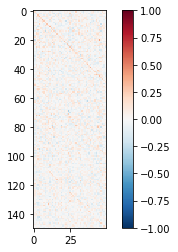

In [52]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 80
time_lags = np.array([1, 2, 144])
init = {"W": 1 * np.random.randn(dim1, rank), "X": 1 * np.random.randn(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))
plt.imshow(A, vmax = 1, vmin = -1, cmap = 'RdBu_r')
plt.colorbar()

Iter: 100
MAPE: 0.0900868
RMSE: 3.81126

Iter: 200
MAPE: 0.0830814
RMSE: 3.55204

Iter: 300
MAPE: 0.0804339
RMSE: 3.44529

Iter: 400
MAPE: 0.0791963
RMSE: 3.39871

Iter: 500
MAPE: 0.0784391
RMSE: 3.37128

Iter: 600
MAPE: 0.0779776
RMSE: 3.3555

Iter: 700
MAPE: 0.0775983
RMSE: 3.34116

Iter: 800
MAPE: 0.0773077
RMSE: 3.33343

Iter: 900
MAPE: 0.0770575
RMSE: 3.32724

Iter: 1000
MAPE: 0.0768227
RMSE: 3.32077

Imputation MAPE: 0.0767546
Imputation RMSE: 3.3165

Running time: 8622 seconds


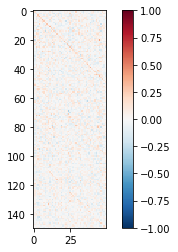

In [50]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 80
time_lags = np.array([1, 2, 144])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))
plt.imshow(A, vmax = 1, vmin = -1, cmap = 'RdBu_r')
plt.colorbar()

**Experiment results** of missing data imputation using BTMF:

|  scenario |`rank`|`burn_iter`|`gibbs_iter`|   mape (%) |      rmse | running time|
|:----------|-----:|----------:|-----------:|-----------:|----------:|------------:|
|**20%, RM**|   80 |      1000 |        100 |   **7.43** |   **3.16**| 6631 seconds|
|**40%, RM**|   80 |      1000 |        100 |   **7.72** |   **3.31**| 6662 seconds|
|**20%, NM**|   10 |      1000 |        100 |  **10.19** |   **4.27**| 1295 seconds|
|**40%, NM**|   10 |      1000 |        100 |  **10.38** |   **4.48**| 1359 seconds|


## Evaluation on Birmingham Parking Data

In [10]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Birmingham-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
# binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
#               .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [19]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 18])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
MAPE: 0.139171
RMSE: 70.9457

Iter: 200
MAPE: 0.128106
RMSE: 64.2559

Iter: 300
MAPE: 0.128823
RMSE: 68.0499

Iter: 400
MAPE: 0.125843
RMSE: 63.4395

Iter: 500
MAPE: 0.125164
RMSE: 68.9003

Iter: 600
MAPE: 0.122415
RMSE: 70.8061

Iter: 700
MAPE: 0.110754
RMSE: 66.7206

Iter: 800
MAPE: 0.111184
RMSE: 67.7515

Iter: 900
MAPE: 0.111919
RMSE: 68.3749

Iter: 1000
MAPE: 0.10921
RMSE: 63.6893

Imputation MAPE: 0.112188
Imputation RMSE: 70.1677

Running time: 228 seconds


In [20]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Birmingham-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
              .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
# binary_tensor = np.zeros(tensor.shape)
# for i1 in range(tensor.shape[0]):
#     for i2 in range(tensor.shape[1]):
#         binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
# binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [21]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 20
time_lags = np.array([1, 2, 18])
init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
MAPE: 0.0538567
RMSE: 30.7521

Iter: 200
MAPE: 0.04131
RMSE: 16.6735

Iter: 300
MAPE: 0.0411135
RMSE: 17.5314

Iter: 400
MAPE: 0.0416663
RMSE: 17.6077

Iter: 500
MAPE: 0.0416849
RMSE: 17.6255

Iter: 600
MAPE: 0.0417459
RMSE: 17.4746

Iter: 700
MAPE: 0.0425088
RMSE: 17.9492

Iter: 800
MAPE: 0.042974
RMSE: 17.4492

Iter: 900
MAPE: 0.0431814
RMSE: 17.231

Iter: 1000
MAPE: 0.0430747
RMSE: 17.6269

Imputation MAPE: 0.0427339
Imputation RMSE: 16.9464

Running time: 279 seconds


**Experiment results** of missing data imputation using BTMF:

|  scenario |`rank`|`burn_iter`|`gibbs_iter`|   mape (%) |      rmse |
|:----------|-----:|----------:|-----------:|-----------:|----------:|
|**10%, RM**|   20 |      1000 |        100 |   **1.76** |   **6.97**|
|**30%, RM**|   20 |      1000 |        100 |   **2.48** |  **15.14**|
|**10%, NM**|   10 |      1000 |        100 |  **11.86** |  **31.87**|
|**30%, NM**|   10 |      1000 |        100 |  **15.20** |  **50.86**|


## Evaluation on Hangzhou Flow Data

In [8]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
              .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
# binary_tensor = np.zeros(tensor.shape)
# for i1 in range(tensor.shape[0]):
#     for i2 in range(tensor.shape[1]):
#         binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
# binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [9]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 50
time_lags = np.array([1, 2, 108])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
MAPE: 0.241205
RMSE: 36.0507

Iter: 200
MAPE: 0.245868
RMSE: 34.1376

Iter: 300
MAPE: 0.249751
RMSE: 33.383

Iter: 400
MAPE: 0.251897
RMSE: 32.1994

Iter: 500
MAPE: 0.247136
RMSE: 31.9517

Iter: 600
MAPE: 0.245257
RMSE: 32.0088

Iter: 700
MAPE: 0.247828
RMSE: 31.5412

Iter: 800
MAPE: 0.246775
RMSE: 31.3818

Iter: 900
MAPE: 0.240857
RMSE: 31.2735

Iter: 1000
MAPE: 0.24017
RMSE: 31.2624

Imputation MAPE: 0.240735
Imputation RMSE: 31.2875

Running time: 979 seconds


In [22]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
dense_mat = dense_mat.astype('float')
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
              .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
# binary_tensor = np.zeros(tensor.shape)
# for i1 in range(tensor.shape[0]):
#     for i2 in range(tensor.shape[1]):
#         binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
# binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [23]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 30
time_lags = np.array([1, 2, 108])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
mat_hat, W, X_new, A = BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
MAPE: 0.22251
RMSE: 35.2192

Iter: 200
MAPE: 0.225725
RMSE: 34.5857

Iter: 300
MAPE: 0.225954
RMSE: 34.3367

Iter: 400
MAPE: 0.223124
RMSE: 34.4635

Iter: 500
MAPE: 0.224683
RMSE: 34.3981

Iter: 600
MAPE: 0.226757
RMSE: 34.5107

Iter: 700
MAPE: 0.225605
RMSE: 34.1594

Iter: 800
MAPE: 0.223803
RMSE: 33.7696

Iter: 900
MAPE: 0.227544
RMSE: 33.7554

Iter: 1000
MAPE: 0.228654
RMSE: 33.6739

Imputation MAPE: 0.226451
Imputation RMSE: 33.5824

Running time: 726 seconds


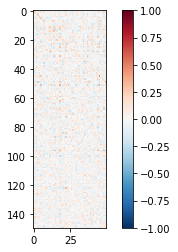

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(A, vmax = 1, vmin = -1, cmap = 'RdBu_r')
plt.colorbar()

**Experiment results** of missing data imputation using BTMF:

- With scalar $\tau$:

|  scenario |`rank`|`burn_iter`|`gibbs_iter`|   mape (%) |      rmse |
|:----------|-----:|----------:|-----------:|-----------:|----------:|
|**20%, RM**|   50 |      1000 |        100 |  **22.35** |  **28.30**|
|**40%, RM**|   50 |      1000 |        100 |  **24.07** |  **31.29**|
|**20%, NM**|   50 |      1000 |        100 |  **24.71** |  **33.77**|
|**40%, NM**|   50 |      1000 |        100 |  **25.92** |  **40.14**|

- With vector $\boldsymbol{\tau}$:

|  scenario |`rank`|`burn_iter`|`gibbs_iter`|   mape (%) |      rmse |
|:----------|-----:|----------:|-----------:|-----------:|----------:|
|**40%, RM**|   50 |      1000 |        100 |  **22.82** |  **34.08**|
|**40%, NM**|   50 |      1000 |        100 |  **-** |  **-**|



## Evaluation on Seattle Speed Data

In [8]:
import pandas as pd

dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0)
NM_mat = pd.read_csv('../datasets/Seattle-data-set/NM_mat.csv', index_col = 0)
dense_mat = dense_mat.values
NM_mat = NM_mat.values

missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
# binary_mat = np.round(RM_mat + 0.5 - missing_rate)
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros((dense_mat.shape[0], 28, 288))
for i1 in range(binary_tensor.shape[0]):
    for i2 in range(binary_tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(NM_mat[i1, i2] + 0.5 - missing_rate)
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_tensor.reshape([dense_mat.shape[0], dense_mat.shape[1]]))

In [9]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 288])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
MAPE: 0.0920831
RMSE: 5.28864

Iter: 200
MAPE: 0.0920516
RMSE: 5.32558

Iter: 300
MAPE: 0.0920244
RMSE: 5.32542

Iter: 400
MAPE: 0.0920333
RMSE: 5.32588

Iter: 500
MAPE: 0.0920408
RMSE: 5.3263

Iter: 600
MAPE: 0.0920483
RMSE: 5.32617

Iter: 700
MAPE: 0.0920579
RMSE: 5.32743

Iter: 800
MAPE: 0.0920623
RMSE: 5.32715

Iter: 900
MAPE: 0.0920595
RMSE: 5.32703

Iter: 1000
MAPE: 0.0920189
RMSE: 5.32679

Imputation MAPE: 0.0920279
Imputation RMSE: 5.32703

Running time: 1316 seconds


**Experiment results** of missing data imputation using BTMF:

|  scenario |`rank`|`burn_iter`|`gibbs_iter`|   mape (%) |      rmse | running time|
|:----------|-----:|----------:|-----------:|-----------:|----------:|------------:|
|**20%, RM**|   50 |      1000 |        100 |   **5.92** |   **3.71**| 3813 seconds|
|**40%, RM**|   50 |      1000 |        100 |   **6.09** |   **3.79**| 3937 seconds|
|**20%, NM**|   10 |      1000 |        100 |   **9.12** |   **5.27**| 1312 seconds|
|**40%, NM**|   10 |      1000 |        100 |   **9.20** |   **5.33**| 1316 seconds|


## Evaluation on London Movement Speed Data

If want to test on the full dataset, you could consider the following setting for masking observations as missing values. 

```python
import numpy as np
np.random.seed(1000)

mask_rate = 0.20

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
pos_obs = np.where(dense_mat != 0)
num = len(pos_obs[0])
sample_ind = np.random.choice(num, size = int(mask_rate * num), replace = False)
sparse_mat = dense_mat.copy()
sparse_mat[pos_obs[0][sample_ind], pos_obs[1][sample_ind]] = 0
```

Notably, you could also consider to evaluate the model on a subset of the data with the following setting.

In [8]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.4

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.8 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

### Random missing (RM) scenario:
# random_mat = np.random.rand(dense_mat.shape[0], dense_mat.shape[1])
# binary_mat = np.round(random_mat + 0.5 - missing_rate)

### Non-random missing (NM) scenario:
binary_mat = np.zeros(dense_mat.shape)
random_mat = np.random.rand(dense_mat.shape[0], 30)
for i1 in range(dense_mat.shape[0]):
    for i2 in range(30):
        binary_mat[i1, i2 * 24 : (i2 + 1) * 24] = np.round(random_mat[i1, i2] + 0.5 - missing_rate)

sparse_mat = np.multiply(dense_mat, binary_mat)

In [9]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 20
time_lags = np.array([1, 2, 24])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
MAPE: 0.0946488
RMSE: 2.28443

Iter: 200
MAPE: 0.0946061
RMSE: 2.29898

Iter: 300
MAPE: 0.0946013
RMSE: 2.29894

Iter: 400
MAPE: 0.0946069
RMSE: 2.29895

Iter: 500
MAPE: 0.0946
RMSE: 2.29882

Iter: 600
MAPE: 0.0946037
RMSE: 2.29887

Iter: 700
MAPE: 0.0946048
RMSE: 2.29889

Iter: 800
MAPE: 0.094599
RMSE: 2.29877

Iter: 900
MAPE: 0.0946041
RMSE: 2.29882

Iter: 1000
MAPE: 0.0945957
RMSE: 2.29878

Imputation MAPE: 0.0946055
Imputation RMSE: 2.29895

Running time: 3985 seconds


**Experiment results** of missing data imputation using BTMF:

|  scenario |`rank`|`burn_iter`|`gibbs_iter`|   mape (%) |      rmse | running time|
|:----------|-----:|----------:|-----------:|-----------:|----------:|------------:|
|**20%, RM**|   20 |      1000 |        100 |   **9.03** |   **2.19**| 3885 seconds|
|**40%, RM**|   20 |      1000 |        100 |   **9.09** |   **2.20**| 3872 seconds|
|**20%, NM**|   20 |      1000 |        100 |   **9.33** |   **2.26**| 4150 seconds|
|**40%, NM**|   20 |      1000 |        100 |   **9.46** |   **2.30**| 3985 seconds|


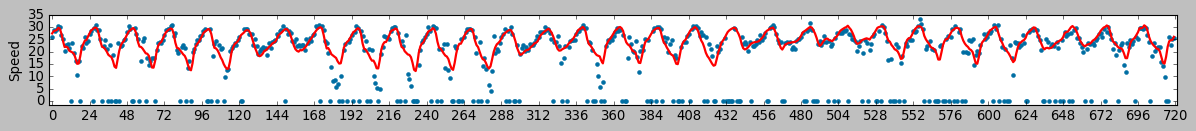

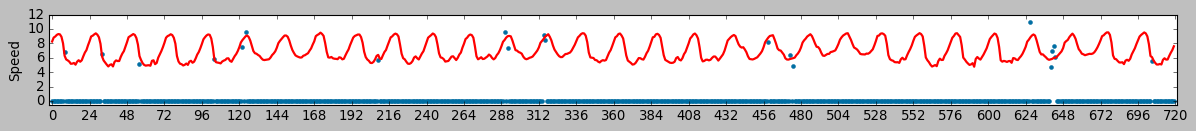

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

for loc in [2, 3]:
    plt.style.use('classic')
    fig = plt.figure(figsize = (15, 1.5))
    ax = fig.add_axes([0.04, 0.18, 0.94, 0.75])
    plt.plot(sparse_mat[loc, :], '.', markersize = 7, color = "#006ea3")
    plt.plot(mat_hat[loc, :], color = 'red', linewidth = 2)
    plt.xticks(np.arange(0, 24 * 30 + 1, 24))
    plt.xlim([-2, 721])
    if loc == 2:
        plt.ylim([-1.5, 35])
    elif loc == 3:
        plt.ylim(-0.5, 12)
    plt.ylabel('Speed')
    plt.show()
    fig.savefig("../images/london_movement_speed_impute{}.pdf".format(loc + 1))

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>